# Восстановление золота из руды

Нужно подготовить прототип модели машинного обучения для компании «Цифры». Компания разрабатывает решения для эффективной работы промышленных предприятий.

Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. Предоставлены данные с параметрами добычи и очистки. Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.



## Технологический процесс

Когда добытая руда проходит первичную обработку, получается дроблёная смесь. Её отправляют на флотацию (обогащение) и двухэтапную очистку.

Опишем каждую стадию:
1. Флотация
Во флотационную установку подаётся смесь золотосодержащей руды. После обогащения получается черновой концентрат и «отвальные хвосты», то есть остатки продукта с низкой концентрацией ценных металлов.
На стабильность этого процесса влияет непостоянное и неоптимальное физико-химическое состояние флотационной пульпы (смеси твёрдых частиц и жидкости).
2. Очистка
Черновой концентрат проходит две очистки. На выходе получается финальный концентрат и новые отвальные хвосты.

## Описание данных


**Технологический процесс**

* **Rougher feed** — исходное сырье
* **Rougher additions** (или reagent additions) — флотационные реагенты: Xanthate, Sulphate, Depressant
* **Xanthate** — ксантогенат (промотер, или активатор флотации);
* **Sulphate** — сульфат (на данном производстве сульфид натрия);
* **Depressant** — депрессант (силикат натрия).
* **Rougher process** (англ. «грубый процесс») — флотация
* **Rougher tails** — отвальные хвосты
* **Float banks** — флотационная установка
* **Cleaner process** — очистка
* **Rougher Au** — черновой концентрат золота
* **Final Au** — финальный концентрат золота

**Параметры этапов**


* **air amount** — объём воздуха
* **fluid levels** — уровень жидкости
* **feed size** — размер гранул сырья
* **feed rate** — скорость подачи


**Наименование признаков**


[этап].[тип_параметра].[название_параметра]  (Пример: rougher.input.feed_ag)




**Возможные значения для блока** [этап]:
* **rougher** — флотация
* **primary_cleaner** — первичная очистка
* **secondary_cleaner** — вторичная очистка
* **final** — финальные характеристики


**Возможные значения для блока** [тип_параметра]:
* **input** — параметры сырья
* **output** — параметры продукта
* **state** — параметры, характеризующие текущее состояние этапа
* **calculation** — расчётные характеристики

## Подготовка данных

In [1]:
# Импортируем библиотеки

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import gdown

from google.colab import drive
from sklearn.metrics import make_scorer, mean_absolute_error
from sklearn.model_selection import  cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.dummy import DummyRegressor

import warnings
warnings.simplefilter('ignore')

In [2]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Читаем данные из CSV-файлов

df_full = pd.read_csv('/content/drive/MyDrive/Projects/Prediction_of_gold_recovery_rate/datasets/gold_industry_full.csv')
df_test = pd.read_csv('/content/drive/MyDrive/Projects/Prediction_of_gold_recovery_rate/datasets/gold_industry_test.csv')
df_train = pd.read_csv('/content/drive/MyDrive/Projects/Prediction_of_gold_recovery_rate/datasets/gold_industry_train.csv')

In [4]:
# Функция для вывода информации об изучаемых данных

def data_info(data):

    display(data.head(10))
    display(data.describe())
    print(data.isna().mean())
    print('Количество дубликатов:', sum(data.duplicated()))

In [5]:
data_info(df_full)

,date,rougher.input.feed_au,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_sol,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.state.floatbank10_a_air,...,secondary_cleaner.output.tail_sol,final.output.concentrate_au,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.recovery,final.output.tail_au,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol
0,2016-01-15 00:00:00,6.486150,6.100378,2.284912,36.808594,523.546326,55.486599,11.986616,6.007990,999.706909,...,8.764648,42.192020,6.055403,9.889648,5.507324,70.541216,2.143149,10.411962,0.895447,16.904297
1,2016-01-15 01:00:00,6.478583,6.161113,2.266033,35.753385,525.290581,57.278666,11.971193,6.005766,1000.286398,...,9.001494,42.701629,6.029369,9.968944,5.257781,69.266198,2.224930,10.462676,0.927452,16.634514
2,2016-01-15 02:00:00,6.362222,6.116455,2.159622,35.971630,530.026610,57.510649,11.920603,6.197377,999.719565,...,8.842896,42.657501,6.055926,10.213995,5.383759,68.116445,2.257889,10.507046,0.953716,16.208849
3,2016-01-15 03:00:00,6.118189,6.043309,2.037807,36.862241,542.590390,57.792734,11.630094,6.203177,999.814770,...,9.122857,42.689819,6.047977,9.977019,4.858634,68.347543,2.146849,10.422762,0.883763,16.532835
4,2016-01-15 04:00:00,5.663707,6.060915,1.786875,34.347666,540.531893,56.047189,10.957755,6.198826,999.678690,...,8.871028,42.774141,6.148599,10.142511,4.939416,66.927016,2.055292,10.360302,0.792826,16.525686
5,2016-01-15 05:00:00,5.687168,5.801920,1.879351,35.470082,546.173470,57.469578,11.072517,6.200383,999.934134,...,9.302669,41.633678,6.482968,10.049416,5.480257,69.465816,1.918586,10.182708,0.664118,16.999638
6,2016-01-15 06:00:00,6.038436,6.056253,2.105501,34.920570,523.376439,56.674647,11.535899,6.204974,999.832373,...,9.103047,41.995316,6.533849,10.058141,4.569100,69.300835,2.058913,10.304598,0.807342,16.723575
7,2016-01-15 07:00:00,6.433854,5.955053,2.310432,36.091386,549.842749,56.730325,12.557906,6.799275,1000.166602,...,9.369209,42.452727,6.130823,9.935481,4.389813,70.230976,2.143437,10.443288,0.949346,16.689959
8,2016-01-15 08:00:00,6.526612,5.878084,2.391713,35.753879,560.115242,56.649893,13.166128,6.798659,1000.026864,...,9.437044,43.404078,5.834140,10.071156,4.876389,69.688595,2.209881,10.420140,1.065453,17.201948
9,2016-01-15 09:00:00,6.747693,5.974832,2.539114,38.553938,566.616045,60.308763,13.996130,6.800263,1000.332327,...,9.582874,43.487291,5.706261,10.242511,5.214161,70.973641,2.200997,10.473539,1.171183,17.717049


,rougher.input.feed_au,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_sol,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,...,secondary_cleaner.output.tail_sol,final.output.concentrate_au,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.recovery,final.output.tail_au,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol
count,19439.000000,19439.000000,19339.000000,19340.000000,19428.000000,19294.000000,19405.000000,19431.000000,19438.000000,19438.000000,...,17691.000000,19439.000000,19438.000000,19438.000000,19228.000000,19439.000000,19439.000000,19438.000000,19338.000000,19433.000000
mean,8.266097,8.794927,3.598085,36.695114,478.320042,58.970310,12.334373,6.021474,1105.315068,-376.610690,...,7.167247,44.076513,5.168470,9.978895,9.501224,67.050208,3.042467,9.688589,2.705795,10.583728
std,1.955092,1.936847,1.049486,5.145445,105.373758,21.634478,3.427317,1.127263,160.826798,93.909667,...,3.916079,5.129784,1.372348,1.669240,2.787537,10.125840,0.922808,2.328642,0.949077,2.868782
min,0.010000,0.010000,0.010000,0.010000,0.002986,0.046369,0.001083,0.000568,-0.042069,-657.949759,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6.854384,7.237967,2.887280,34.207799,416.525453,47.435103,10.000362,5.398678,999.661867,-499.835165,...,3.845475,43.402215,4.251240,9.137262,7.722820,63.299712,2.461138,8.062878,2.040119,8.938947
50%,8.125839,8.593574,3.534895,37.202650,499.416120,54.610197,12.001174,6.008273,1001.072890,-300.263994,...,7.685827,45.011244,5.066094,10.102433,9.218961,68.172738,2.984909,9.743623,2.748730,10.622456
75%,9.769917,10.213771,4.244161,40.039133,550.172183,65.023044,14.716595,6.798051,1205.620588,-299.981998,...,10.411296,46.275313,5.895527,11.035769,10.947813,72.686642,3.571351,11.134294,3.333216,12.104271
max,13.731330,14.596026,7.142594,53.477742,717.508837,484.967466,36.118275,9.703448,1521.980372,-273.776101,...,26.000772,52.756638,16.001945,17.031899,19.615720,100.000000,8.245022,19.552149,5.804178,22.317730


date                      0.000000
rougher.input.feed_au     0.000000
rougher.input.feed_ag     0.000000
rougher.input.feed_pb     0.005144
rougher.input.feed_sol    0.005093
                            ...   
final.output.recovery     0.000000
final.output.tail_au      0.000000
final.output.tail_ag      0.000051
final.output.tail_pb      0.005196
final.output.tail_sol     0.000309
Length: 87, dtype: float64
Количество дубликатов: 0


In [6]:
data_info(df_train)

,date,rougher.input.feed_au,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_sol,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.state.floatbank10_a_air,...,secondary_cleaner.output.tail_sol,final.output.concentrate_au,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.recovery,final.output.tail_au,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol
0,2016-01-15 00:00:00,6.486150,6.100378,2.284912,36.808594,523.546326,55.486599,11.986616,6.007990,999.706909,...,8.764648,42.192020,6.055403,9.889648,5.507324,70.541216,2.143149,10.411962,0.895447,16.904297
1,2016-01-15 01:00:00,6.478583,6.161113,2.266033,35.753385,525.290581,57.278666,11.971193,6.005766,1000.286398,...,9.001494,42.701629,6.029369,9.968944,5.257781,69.266198,2.224930,10.462676,0.927452,16.634514
2,2016-01-15 02:00:00,6.362222,6.116455,2.159622,35.971630,530.026610,57.510649,11.920603,6.197377,999.719565,...,8.842896,42.657501,6.055926,10.213995,5.383759,68.116445,2.257889,10.507046,0.953716,16.208849
3,2016-01-15 03:00:00,6.118189,6.043309,2.037807,36.862241,542.590390,57.792734,11.630094,6.203177,999.814770,...,9.122857,42.689819,6.047977,9.977019,4.858634,68.347543,2.146849,10.422762,0.883763,16.532835
4,2016-01-15 04:00:00,5.663707,6.060915,1.786875,34.347666,540.531893,56.047189,10.957755,6.198826,999.678690,...,8.871028,42.774141,6.148599,10.142511,4.939416,66.927016,2.055292,10.360302,0.792826,16.525686
5,2016-01-15 05:00:00,5.687168,5.801920,1.879351,35.470082,546.173470,57.469578,11.072517,6.200383,999.934134,...,9.302669,41.633678,6.482968,10.049416,5.480257,69.465816,1.918586,10.182708,0.664118,16.999638
6,2016-01-15 06:00:00,6.038436,6.056253,2.105501,34.920570,523.376439,56.674647,11.535899,6.204974,999.832373,...,9.103047,41.995316,6.533849,10.058141,4.569100,69.300835,2.058913,10.304598,0.807342,16.723575
7,2016-01-15 07:00:00,6.433854,5.955053,2.310432,36.091386,549.842749,56.730325,12.557906,6.799275,1000.166602,...,9.369209,42.452727,6.130823,9.935481,4.389813,70.230976,2.143437,10.443288,0.949346,16.689959
8,2016-01-15 08:00:00,6.526612,5.878084,2.391713,35.753879,560.115242,56.649893,13.166128,6.798659,1000.026864,...,9.437044,43.404078,5.834140,10.071156,4.876389,69.688595,2.209881,10.420140,1.065453,17.201948
9,2016-01-15 09:00:00,6.747693,5.974832,2.539114,38.553938,566.616045,60.308763,13.996130,6.800263,1000.332327,...,9.582874,43.487291,5.706261,10.242511,5.214161,70.973641,2.200997,10.473539,1.171183,17.717049


,rougher.input.feed_au,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_sol,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,...,secondary_cleaner.output.tail_sol,final.output.concentrate_au,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.recovery,final.output.tail_au,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol
count,14579.000000,14579.000000,14507.000000,14502.000000,14572.000000,14478.000000,14548.000000,14572.000000,14579.000000,14579.000000,...,13659.000000,14579.000000,14578.000000,14578.000000,14387.000000,14579.000000,14579.000000,14578.000000,14504.000000,14574.000000
mean,8.352941,8.877460,3.604221,36.561420,474.332784,58.922712,12.427399,5.994854,1104.208278,-379.367166,...,7.111347,43.979499,5.192145,9.923809,9.566676,66.759066,3.087939,9.731972,2.719985,10.612745
std,1.934376,1.922536,1.056063,5.209823,108.503552,22.407410,3.428939,1.152873,162.235606,94.652311,...,3.909951,5.471437,1.388014,1.706976,2.805654,10.619709,0.915187,2.358143,0.958929,2.871075
min,0.010000,0.010000,0.010000,0.010000,0.002986,0.049194,0.001083,0.000568,-0.042069,-657.949759,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6.932996,7.341922,2.880490,34.093951,411.048483,47.278490,10.002832,5.304167,999.644856,-499.861797,...,3.784897,43.345906,4.283347,9.103183,7.860030,63.114596,2.505287,8.088928,2.036512,9.013412
50%,8.225284,8.715859,3.532399,37.097511,498.187968,54.361187,12.003320,6.003053,1000.982624,-300.314199,...,7.629968,44.975014,5.118647,10.046455,9.301970,67.962788,3.029238,9.818512,2.774847,10.670515
75%,9.832210,10.255843,4.257282,39.899799,549.586552,64.464926,14.929903,6.796632,1292.663971,-299.989315,...,10.367050,46.275153,5.925380,10.981203,11.001573,72.598187,3.614098,11.169187,3.353845,12.130827
max,13.731330,14.596026,7.052325,53.475325,717.508837,484.967466,36.118275,9.703448,1512.299531,-273.776101,...,26.000772,52.756638,16.001945,16.705297,19.423912,100.000000,8.245022,19.552149,5.804178,22.317730


date                      0.000000
rougher.input.feed_au     0.000000
rougher.input.feed_ag     0.000000
rougher.input.feed_pb     0.004939
rougher.input.feed_sol    0.005282
                            ...   
final.output.recovery     0.000000
final.output.tail_au      0.000000
final.output.tail_ag      0.000069
final.output.tail_pb      0.005144
final.output.tail_sol     0.000343
Length: 87, dtype: float64
Количество дубликатов: 0


In [7]:
data_info(df_test)

,date,rougher.input.feed_au,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_sol,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.state.floatbank10_a_air,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2017-12-09 14:59:59,4.365491,6.158718,3.875727,39.135119,555.820208,94.544358,6.146982,9.308612,1196.238112,...,23.018622,-500.492702,20.020205,-500.220296,17.963512,-499.939490,12.990306,-500.080993,19.990336,-499.191575
1,2017-12-09 15:59:59,4.362781,6.048130,3.902537,39.713906,544.731687,123.742430,6.210119,9.297709,1201.904177,...,23.024963,-501.153409,20.054122,-500.314711,17.979515,-499.272871,12.992404,-499.976268,20.013986,-500.625471
2,2017-12-09 16:59:59,5.081681,6.082745,4.564078,37.208683,558.155110,82.610855,7.363824,9.003562,1200.826926,...,22.993827,-501.559663,20.029144,-500.000662,18.012723,-500.024764,13.016445,-500.058432,19.973767,-501.394155
3,2017-12-09 17:59:59,5.145949,6.084374,4.768124,36.808874,539.713765,77.984784,6.927072,8.955597,1199.292489,...,23.032807,-501.287889,19.977466,-500.159903,17.980463,-500.504602,12.949071,-500.009937,20.010332,-508.337973
4,2017-12-09 18:59:59,5.735249,6.165220,4.512346,37.810642,558.713584,86.434874,7.823471,7.490356,1198.005449,...,23.001911,-499.947838,20.023735,-499.713680,17.990955,-500.334769,13.007523,-499.968459,19.995999,-499.788805
5,2017-12-09 19:59:59,5.848338,6.234198,4.468803,37.816555,547.515088,85.875864,8.040386,7.500718,1201.408796,...,22.977833,-499.910098,20.000113,-500.584093,18.003899,-500.326371,12.978611,-499.966502,19.988673,-500.742891
6,2017-12-09 20:59:59,6.172839,6.213598,4.458071,36.829223,518.363800,73.426294,7.641859,7.498470,1198.551240,...,22.964590,-500.083299,20.010567,-500.545746,18.040164,-498.936442,12.988702,-499.985412,20.014155,-499.443855
7,2017-12-09 21:59:59,5.743825,6.264367,4.428267,37.170131,500.494798,75.915232,7.230213,7.496599,1201.172468,...,23.010484,-500.498525,20.043525,-499.701442,17.991164,-500.324632,13.000809,-500.181711,20.001605,-500.229965
8,2017-12-09 22:59:59,5.558520,6.167472,4.370640,37.356892,540.990643,79.668503,7.089240,7.524634,1195.305111,...,22.979813,-500.451722,19.995022,-500.415107,18.057379,-499.238503,13.011922,-500.067255,20.002796,-504.347015
9,2017-12-09 23:59:59,5.473143,6.076597,4.274908,38.631317,492.146649,90.792119,7.367698,6.543369,1203.076302,...,23.050901,-501.185001,20.016755,-499.840744,17.991566,-500.303770,13.023215,-500.018271,20.015115,-515.537548


,rougher.input.feed_au,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_sol,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,4860.000000,4860.000000,4832.000000,4838.000000,4856.000000,4816.000000,4857.000000,4859.000000,4859.000000,4859.000000,...,4.859000e+03,4859.000000,4.859000e+03,4859.000000,4859.000000,4859.000000,4859.000000,4859.000000,4859.000000,4859.000000
mean,8.005584,8.547348,3.579662,37.095864,490.285103,59.113400,12.055735,6.101308,1108.635895,-368.340127,...,1.985770e+01,-488.665140,1.557025e+01,-464.176507,16.594103,-490.815250,12.945971,-489.583564,19.053888,-504.678924
std,1.993590,1.958601,1.029377,4.926284,94.371623,19.125122,3.407642,1.042754,156.493143,91.155929,...,5.913105e+00,44.392714,4.927361e+00,65.706994,5.724305,32.258443,5.533176,37.084609,5.548996,38.690186
min,0.010000,0.010000,0.010000,0.010000,0.012786,0.046369,0.018907,0.015783,300.792494,-600.568138,...,1.079872e-16,-799.704969,2.489718e-17,-799.860767,-0.371498,-797.142475,1.358469,-800.006180,0.160386,-809.734800
25%,6.574363,6.975898,2.903612,34.510841,434.099695,47.596984,9.890429,5.499808,999.715729,-499.731972,...,1.501123e+01,-500.704004,1.202172e+01,-500.196517,11.073822,-500.483564,9.011890,-500.129913,14.963953,-500.668501
50%,7.812923,8.179714,3.540772,37.499761,502.118742,55.509481,11.997859,6.099805,1001.414798,-300.181367,...,1.996807e+01,-499.892919,1.501240e+01,-499.540776,16.631195,-499.873136,11.999417,-499.955304,19.960006,-500.033769
75%,9.556589,10.084339,4.199847,40.461315,555.596563,66.661547,14.496072,6.802101,1202.837565,-299.961547,...,2.498900e+01,-498.652030,1.999949e+01,-400.302329,19.983191,-498.852815,15.004198,-499.643776,24.974583,-499.460134
max,13.417156,14.533698,7.142594,53.477742,702.523396,363.989699,30.010759,9.396928,1521.980372,-281.039299,...,3.008450e+01,-383.373053,2.398898e+01,-114.250832,33.215996,-288.963521,24.177106,-141.934397,32.028529,-104.427459


date                                          0.000000
rougher.input.feed_au                         0.000000
rougher.input.feed_ag                         0.000000
rougher.input.feed_pb                         0.005761
rougher.input.feed_sol                        0.004527
rougher.input.feed_rate                       0.000823
rougher.input.feed_size                       0.009053
rougher.input.floatbank10_sulfate             0.000617
rougher.input.floatbank10_xanthate            0.000206
rougher.state.floatbank10_a_air               0.000206
rougher.state.floatbank10_a_level             0.000206
rougher.state.floatbank10_b_air               0.000206
rougher.state.floatbank10_b_level             0.000206
rougher.state.floatbank10_c_air               0.000206
rougher.state.floatbank10_c_level             0.000206
rougher.state.floatbank10_d_air               0.000000
rougher.state.floatbank10_d_level             0.000000
rougher.state.floatbank10_e_air               0.001440
rougher.st

Предоставлены три выборки full, train, test. Выборки разного размера. В выборке test отсутсвтуют целевые признаки. В данных присутствуют пропуски, дублкатов нет.

### Проверка расчётов эффективности обогащения

Эффективность обогащения рассчитывается по формуле
Recovery = ((C*(F-T))/(F*(C-T))*100%

где:

C — доля золота в концентрате после флотации/очистки;

F — доля золота в сырье/концентрате до флотации/очистки;

T — доля золота в отвальных хвостах после флотации/очистки.

Для прогноза коэффициента нужно найти долю золота в концентратах и хвостах. Причём важен не только финальный продукт, но и черновой концентрат.

In [8]:
# Вычислим эффективность обогащения на обучающей выборке
C = df_train['rougher.output.concentrate_au']
F = df_train['rougher.input.feed_au']
T = df_train['rougher.output.tail_au']

In [9]:
# Создадим новый столбец в котором будут храниться наши вычисления
df_train['recovery_calc'] = ((C*(F-T))/(F*(C-T)))*100
df_train['recovery_calc'].mean().round(2)

82.52

In [10]:
# Сравним с признаком rougher.output.recovery
df_train['rougher.output.recovery'].mean().round(2)

82.52

In [11]:
# Рассчитаем MAE
mean_absolute_error(df_train['recovery_calc'], df_train['rougher.output.recovery'])

9.83758577644259e-15

In [12]:
# Удалим столбец созданный для расчетов
df_train.drop('recovery_calc', axis=1, inplace=True)

Расчитали эффективность обогащения и нашли среднее значение. При сравнении полученного значения и значения из датасета оказалось, что величины почти одинаковы. Значение MAE 9.84e-15. Это говорит о том, что эффективность обогащения рассчитана правильно.

### Анализ признаков, недоступных в тестовой выборке

In [13]:
# Разница между df_train и df_test
list(df_train.columns.difference(df_test.columns))

['final.output.concentrate_ag',
 'final.output.concentrate_au',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_au',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_au',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'rougher.calculation.au_pb_ratio',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_au',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_au',
 'rougher.output.ta

В тестовой выборке отсутствуют 34 признака. Не хватает выходных параметров продукта output на всех этапах техпроцесса, а так же некоторых расчётных характеристик calculation.

### Обработка пропусков

In [14]:
# Выведем информацию о пропусках для контроля
display(sum(df_full.isna().sum()))
display(sum(df_train.isna().sum()))
display(sum(df_test.isna().sum()))

4481

3050

375

In [15]:
# Обработаем пропуски методом ffill
df_full = df_full.ffill()
df_train = df_train.ffill()
df_test = df_test.ffill()

In [16]:
# Проверим, что пропусков не осталось
display(sum(df_full.isna().sum()))
display(sum(df_train.isna().sum()))
display(sum(df_test.isna().sum()))

0

0

0

### Выводы

Предоставлены три выборки full, train, test. Выборки разного размера. В выборке test отсутсвтуют целевые признаки. В данных присутствуют пропуски, дублкатов нет.

* Расчитали эффективность обогащения и нашли среднее значение. При сравнении полученного значения и значения из датасета оказалось, что величины почти одинаковы. Значение MAE 9.84e-15. Это говорит о том, что эффективность обогащения рассчитана правильно.

* В тестовой выборке отсутствуют 34 признака. Не хватает выходных параметров продукта output на всех этапах техпроцесса, а так же некоторых расчётных характеристик calculation.

* Были обработаны пропуски.

## Анализ данных

### Рассмотрим как меняется концентрация металлов (Au, Ag, Pb) на различных этапах: в сырье, в черновом концентрате, в концентрате после первой очистки и в финальном концентрате.

Отфильтруем даные:

In [17]:
# для золота
df_full_au = df_full[['rougher.output.concentrate_au',
              'primary_cleaner.output.concentrate_au',
              'final.output.concentrate_au']]

# для серебра
df_full_ag = df_full[['rougher.output.concentrate_ag',
              'primary_cleaner.output.concentrate_ag',
              'final.output.concentrate_ag']]

# для свинца
df_full_pb = df_full[['rougher.output.concentrate_pb',
              'primary_cleaner.output.concentrate_pb',
              'final.output.concentrate_pb']]

Переименуем столбцы:

In [18]:
# для золота
df_full_au = df_full_au.rename(columns={'rougher.output.concentrate_au': 'Флотация',
                              'primary_cleaner.output.concentrate_au': 'Очистка1',
                              'final.output.concentrate_au': 'Очистка2'})

# для серебра
df_full_ag = df_full_ag.rename(columns={'rougher.output.concentrate_ag': 'Флотация',
                              'primary_cleaner.output.concentrate_ag': 'Очистка1',
                              'final.output.concentrate_ag': 'Очистка2'})

# для свинца
df_full_pb = df_full_pb.rename(columns={'rougher.output.concentrate_pb': 'Флотация',
                              'primary_cleaner.output.concentrate_pb': 'Очистка1',
                              'final.output.concentrate_pb': 'Очистка2'})

Построим графики изменения концентрации металлов

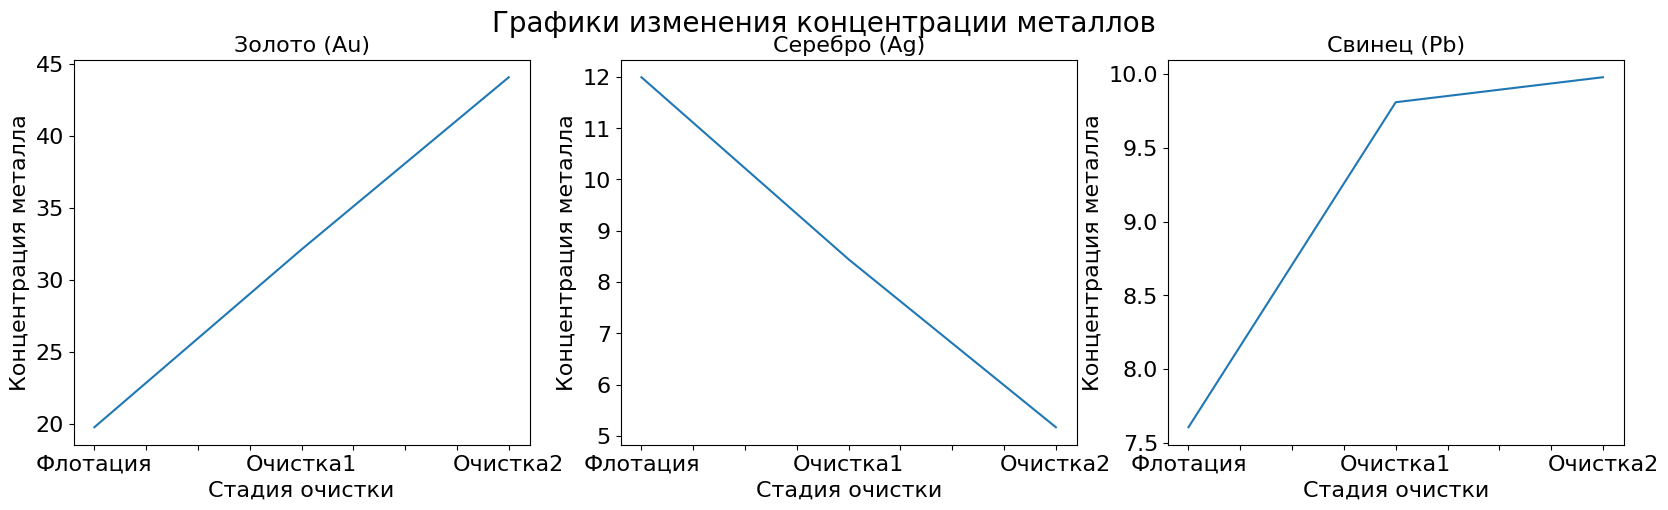

In [19]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 5))

df_full_au.mean().plot(ax=ax1, subplots=True, fontsize=16)
ax1.set_title('Золото (Au)', fontsize=16)
ax1.set_ylabel('Концентрация металла', fontsize=16)
ax1.set_xlabel('Стадия очистки', fontsize=16)

df_full_ag.mean().plot(ax=ax2, subplots=True, fontsize=16)
ax2.set_title('Серебро (Ag)', fontsize=16)
ax2.set_ylabel('Концентрация металла', fontsize=16)
ax2.set_xlabel('Стадия очистки', fontsize=16)

df_full_pb.mean().plot(ax=ax3, subplots=True, fontsize=16)
ax3.set_title('Свинец (Pb)', fontsize=16)
ax3.set_ylabel('Концентрация металла', fontsize=16)
ax3.set_xlabel('Стадия очистки', fontsize=16)


plt.suptitle('Графики изменения концентрации металлов', fontsize=20);

Концентрация золота с каждым этапом очистки увеличивается, концентрация серебра уменьшается, концентрация свинца  увеличивается после флотации и незначительно увеличивается после первого этапа очистки.

###  Сравнение распределения размеров гранул исходного сырья на обучающей и тестовой выборках

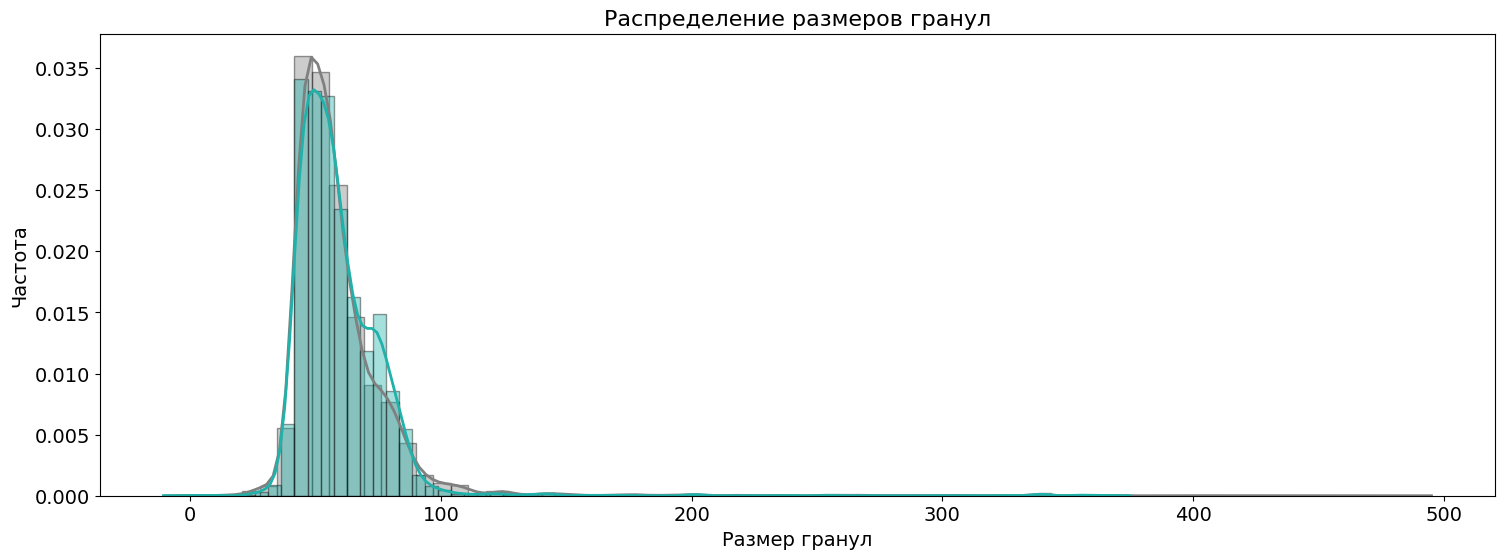

In [20]:
# Построим график распределения размеров гранул

plt.figure(figsize=(18, 6))

sns.distplot(df_train['rougher.input.feed_size'], hist=True, kde=True,
             bins=70, color='Gray',
             hist_kws={'edgecolor': 'black'},
             kde_kws={'linewidth': 2})

sns.distplot(df_test['rougher.input.feed_size'], hist=True, kde=True,
             bins=70, color='LightSeaGreen',
             hist_kws={'edgecolor': 'black'},
             kde_kws={'linewidth': 2}).set(title='Распределение размеров гранул',
                                          xlabel='Размер гранул', ylabel='Частота')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title('Распределение размеров гранул', fontsize=16)
plt.xlabel('Размер гранул', fontsize=14)
plt.ylabel('Частота', fontsize=14)
plt.show()

Размеры гранул сырья на обучающей и тестовой выборках похожи, следовательно оценка модели должна быть корректна.

### Исследование суммарной концентрации металлов на разных стадиях

Исследование суммарной концентрации металлов на разных стадиях: в сырье, в черновом концентрате, в концентрате после первой очистки и в финальном концентрате.

In [21]:
# Hайдем суммарную концентрацию металлов (Au, Ag, Pb) в сырье
sum_feed_me = df_full[['rougher.input.feed_au',
                   'rougher.input.feed_ag',
                   'rougher.input.feed_pb']].sum(axis=1)

# Hайдем суммарную концентрацию металлов (Au, Ag, Pb)  в черновом концентрате
sum_rougher_concentrate_me = df_full[['rougher.output.concentrate_au',
                   'rougher.output.concentrate_ag',
                   'rougher.output.concentrate_pb']].sum(axis=1)

# Hайдем суммарную концентрацию металлов (Au, Ag, Pb)  в концентрате после первой очистки
sum_primary_cleaner_me = df_full[['primary_cleaner.output.concentrate_au',
                   'primary_cleaner.output.concentrate_ag',
                   'primary_cleaner.output.concentrate_pb']].sum(axis=1)

# Hайдем суммарную концентрацию металлов (Au, Ag, Pb) в финальном концентрате
sum_final_me = df_full[['final.output.concentrate_au',
                   'final.output.concentrate_ag',
                   'final.output.concentrate_pb']].sum(axis=1)

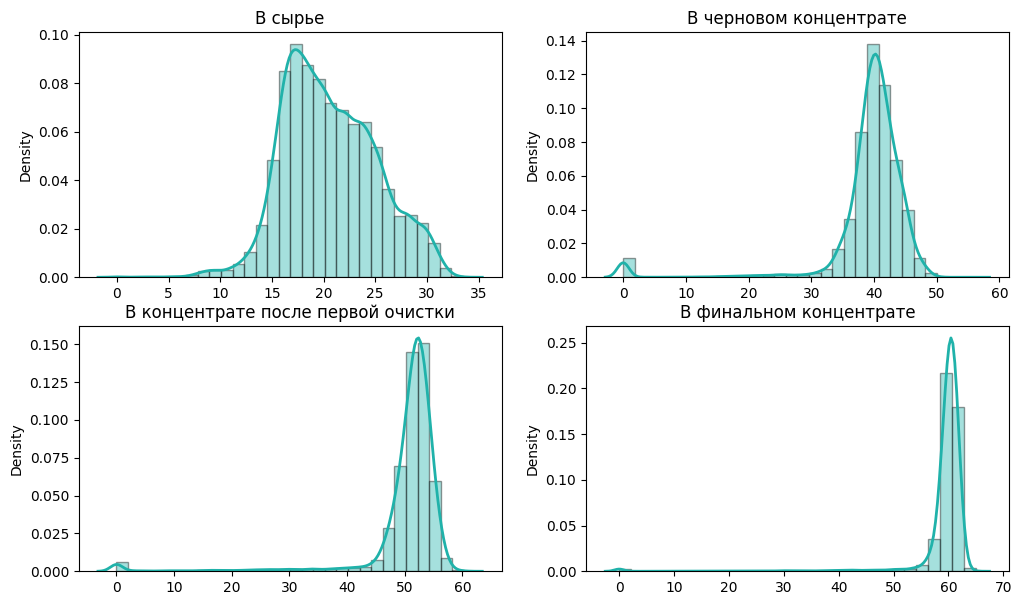

In [22]:
# Построим графики
f, axes = plt.subplots(2, 2, figsize=(12, 7), sharex=False)

sns.distplot(sum_feed_me, hist=True, kde=True,
             bins=30, color = 'LightSeaGreen',
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2},
             ax=axes[0, 0],).set(title='В сырье')

sns.distplot(sum_rougher_concentrate_me, hist=True, kde=True,
             bins=30, color = 'LightSeaGreen',
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2},
             ax=axes[0, 1]).set(title='В черновом концентрате')

sns.distplot(sum_primary_cleaner_me, hist=True, kde=True,
             bins=30, color = 'LightSeaGreen',
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2},
             ax=axes[1, 0]).set(title='В концентрате после первой очистки')

sns.distplot(sum_final_me, hist=True, kde=True,
             bins=30, color = 'LightSeaGreen',
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2},
             ax=axes[1, 1]).set(title='В финальном концентрате');

Было рассмотрено суммарное содержание металлов на разных стадиях технологического процесса. В черновом концентрате, в концентрате после первой очистки и в финальном концентрате наблюдаются аномалии. Суммарная концентрация растет от стадии к стадии.

In [23]:
def remove_less_than_1(df, columns):
    return df.drop(index=df[df[columns].lt(1).any(axis=1)].index, axis=0)

# Столбцы для проверки в df_train
columns_to_check_train = [
    'rougher.input.feed_au', 'rougher.input.feed_ag', 'rougher.input.feed_pb',
    'rougher.output.concentrate_au', 'rougher.output.concentrate_ag', 'rougher.output.concentrate_pb',
    'primary_cleaner.output.concentrate_au', 'primary_cleaner.output.concentrate_ag', 'primary_cleaner.output.concentrate_pb',
    'final.output.concentrate_au', 'final.output.concentrate_ag', 'final.output.concentrate_pb'
]

# Столбцы для проверки в df_test
columns_to_check_test = [
    'rougher.input.feed_au', 'rougher.input.feed_ag', 'rougher.input.feed_pb'
]

# Удаляем строки с содержанием металлов меньше 1 в df_train
df_train = remove_less_than_1(df_train, columns_to_check_train)

# Удаляем строки с содержанием металлов меньше 1 в df_test
df_test = remove_less_than_1(df_test, columns_to_check_test)

In [24]:
# Удаление строк с содержанием металлов меньше 1 в df_train
df_train = remove_less_than_1(df_train, columns_to_check_train)

# Удаление строк с содержанием металлов меньше 1 в df_test
df_test = remove_less_than_1(df_test, columns_to_check_test)

### Выводы

*  Было рассмотрено как меняется концентрация металлов (Au, Ag, Pb) на различных этапах очистки. Оказалось, что концентрация золота с каждым этапом очистки увеличивается, концентрация серебра уменьшается, концентрация свинца увеличивается после флотации и незначительно увеличивается после первого этапа очистки.
* Показано, что размеры гранул сырья на обучающей и тестовой выборках похожи, следовательно оценка модели должна быть корректна.
* Было рассмотрено суммарное содержание металлов на разных стадиях технологического процесса. В черновом концентрате, в концентрате после первой очистки и в финальном концентрате наблюдаются аномалии. Суммарная концентрация растет от стадии к стадии.

## Модель

### Вычисление итогового значения sMAPE

Cимметричная средняя абсолютная процентная ошибка (Symmetric Mean Absolute Percentage Error) — это мера точности, основанная на процентных (или относительных) ошибках.

In [25]:
# Функция для рассчета smape
def smape(target, predictions):
    i = np.abs(target-predictions)
    j =(np.abs(target)+ np.abs(predictions))*0.5
    output = np.divide(i, j)
    output_scores = np.average(output[j != 0], axis=0)

    return output_scores * 100

In [26]:
# Функция для рассчета smape по реальным значениям целевых признаков и предсказаниям моделей
def final_smape(smape_rougher, smape_final):
    return 0.25 * smape_rougher + 0.75 * smape_final

### Обучение моделей и оценка их качества кросс-валидацией

Обучим разные модели и оцените их качество кросс-валидацией. Выберите лучшую модель и проверьте её на тестовой выборке.

Тестовая выборка не полная, подготовим ее для использования в обучении.

In [27]:
# Создадим датасет с целевыми признаками
df_target = df_full[['date', 'rougher.output.recovery', 'final.output.recovery']]

# Соединим с тестовой выборкой
df_test = df_test.merge(df_target, how='left', on='date')

# Удалим столбец с датами
df_test.drop(['date'], axis=1, inplace=True)

# Удалим из тренировочной выборки признаки отсутствующие в тестовой
df_train = df_train.drop(set(df_train.columns)-set(df_test.columns), axis=1)

Подготовим признаки:

In [28]:
# для чернового концентрата (тренировочная)
features_train_rougher = df_train.filter(regex='^rougher',axis=1)
features_train_rougher = features_train_rougher.drop(['rougher.output.recovery'], axis=1)
target_train_rougher = df_train['rougher.output.recovery']

# для финального концентрата (тренировочная)
features_train_final = df_train.drop(['rougher.output.recovery', 'final.output.recovery'], axis=1)
target_train_final = df_train['final.output.recovery']

# для чернового концентрата (тестовая)
features_test_rougher = df_test.filter(regex='^rougher',axis=1)
features_test_rougher = features_test_rougher.drop(['rougher.output.recovery'], axis=1)
target_test_rougher = df_test['rougher.output.recovery']

#  для финального концентрата (тестовая)
features_test_final = df_test.drop(['rougher.output.recovery', 'final.output.recovery'], axis=1)
target_test_final = df_test['final.output.recovery']

In [29]:
# Зафиксируем параметр random state
RANDOM_STATE = 12345

#### DecisionTreeRegressor

In [30]:
# построим модель и сделаем кросс-валидацию
for depth in range(1, 12, 2):
    dtr_model = DecisionTreeRegressor(random_state=RANDOM_STATE, max_depth = depth)
    scorer = make_scorer(smape, greater_is_better=False)
    dtr_rougher = abs(cross_val_score(dtr_model, features_train_rougher, target_train_rougher, scoring=scorer, cv=5))
    dtr_final = abs(cross_val_score(dtr_model, features_train_final, target_train_final, scoring=scorer, cv=5))
    print('Глубина:', depth)
    print('Итоговое sMAPE: {:.2f} %'.format(final_smape(dtr_rougher, dtr_final).mean()))
    print('')

Глубина: 1
Итоговое sMAPE: 8.46 %

Глубина: 3
Итоговое sMAPE: 8.33 %

Глубина: 5
Итоговое sMAPE: 8.80 %

Глубина: 7
Итоговое sMAPE: 10.53 %

Глубина: 9
Итоговое sMAPE: 11.27 %

Глубина: 11
Итоговое sMAPE: 12.71 %



#### LinearRegression

In [31]:
# построим модель и сделаем кросс-валидацию
lr_model = LinearRegression()
scorer = make_scorer(smape, greater_is_better=False)
lr_rougher = abs(cross_val_score(lr_model, features_train_rougher, target_train_rougher, scoring=scorer, cv=5))
lr_final =  abs(cross_val_score(lr_model, features_train_final, target_train_final, scoring=scorer, cv=5))
print('Итоговое sMape: {:.2f} %'.format(final_smape(lr_rougher, lr_final).mean()))

Итоговое sMape: 8.66 %


Лучшее значение sMAPE у модели DecisionTreeRegressor 8.33 % на глубине 3.

### Проверим модель  DecisionTreeRegressor на тестовой выборке

In [32]:
dtr_model_rougher = DecisionTreeRegressor(random_state=RANDOM_STATE, max_depth = 1)
dtr_model_final = DecisionTreeRegressor(random_state=RANDOM_STATE, max_depth = 1)

dtr_model_rougher.fit(features_train_rougher, target_train_rougher)
dtr_model_final.fit(features_train_final, target_train_final)

test_predictions_rougher = dtr_model_rougher.predict(features_test_rougher)
test_predictions_final = dtr_model_final.predict(features_test_final)

print('Итоговое sMAPE: {:.2f} %'.format(final_smape(smape(target_test_rougher, test_predictions_rougher),
                        smape(target_test_final, test_predictions_final))))

Итоговое sMAPE: 8.08 %


In [33]:
# Сравним полученную модель с константной
dummy_model_rougher = DummyRegressor(strategy="mean")
dummy_model_final = DummyRegressor(strategy="mean")
dummy_model_rougher.fit(features_train_rougher, target_train_rougher)
dummy_model_final.fit(features_train_final, target_train_final)
test_predictions_rougher = dummy_model_rougher.predict(features_test_rougher)
test_predictions_final = dummy_model_final.predict(features_test_final)

print('Итоговое sMAPE: {:.2f} %'.format(final_smape(smape(target_test_rougher, test_predictions_rougher),
                        smape(target_test_final, test_predictions_final))))

Итоговое sMAPE: 8.40 %


Итоговое значение sMAPE для полученное на тестовой выборке на ~1% меньше, чем на константной модели.

### Выводы

* Была написана функция для вычисления итоговой sMAPE (симметричной средней абсолютной процентной ошибки).
* Были обучены модели LinearRegression и DecisionTreeRegressor.
* Лучшее значение sMAPE у модели DecisionTreeRegressor 8.33 % на глубине 3.
* Модель была проверена на тестовой выборке. Итоговое значение sMAPE для полученное на тестовой выборке на 1% меньше, чем на константной модели.

## Выводы

Произведен анализ данных техпроцесса получения золота из руды.

**Подготовка данных**

* Были предоставлены три выборки full, train, test. Выборки разного размера. В выборке test отсутсвтуют целевые признаки. В данных присутствуют пропуски, дублкатов нет.

* Расчитали эффективность обогащения и нашли среднее значение. При сравнении полученного значения и значения из датасета оказалось, что величины почти одинаковы. Значение MAE 9.84e-15. Это говорит о том, что эффективность обогащения рассчитана правильно.

* В тестовой выборке отсутствуют 34 признака. Не хватает выходных параметров продукта output на всех этапах техпроцесса, а так же некоторых расчётных характеристик calculation.

**Анализ данных**
* Было показано, что концентрация золота с каждым этапом очистки увеличивается, концентрация серебра уменьшается, концентрация свинца увеличивается после флотации и незначительно увеличивается после первого этапа очистки.

* Сравнили распределения размеров гранул исходного сырья на обучающей и тестовой выборках. Размеры гранул сырья  похожи, следовательно оценка модели должна быть корректна.

* Было рассмотрено суммарное содержание металлов на разных стадиях технологического процесса. В черновом концентрате, в концентрате после первой очистки и в финальном концентрате наблюдаются аномалии. Суммарная концентрация веществ растет от стадии к стадии.

**Построение модели**
* Была написана функция для вычисления итоговой sMAPE (симметричной средней абсолютной процентной ошибки).

* Были обучены модели LinearRegression и DecisionTreeRegressor.

* Лучшее значение sMAPE у модели DecisionTreeRegressor 8.33 % на глубине 3.

* Модель была проверена на тестовой выборке. Итоговое значение sMAPE для полученное на тестовой выборке на 1% меньше, чем на константной модели.